# Preprocess data

In [1]:
import csv
import cv2
import gzip
import matplotlib.pyplot as plt
import numpy as np
import os
import random

from datetime import datetime
from os.path import expanduser
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

home_path = expanduser("~")

In [2]:
def data_generator(samples, shape, batch_size, correction, sensitivity, 
                   angle_threshold):
    num_samples = len(samples)
    rows, cols, ch = shape
    factors = [0, 1, -1]
    
    samples = shuffle(samples)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]

            X = []
            y = []
            for i, sample in enumerate(batch_samples):
                # get steering angle
                angle = float(line[4])
                
                # camera selection
                #  -> drop near-0 angle data with probability
                #  -> [0, 1, 2] = [center, left, right]
                if abs(angle) < angle_threshold and np.random.random() < 0.90:
                    camera = np.random.choice([1, 2])
                else:
                    camera = np.random.choice([0, 1, 2])
                
                adjustment = np.random.uniform(correction-sensitivity, 
                                                   correction+sensitivity)
                
                # adjust angle if needed
                # -> factors[0, 1, -1] = [center, left, right]
                angle += factors[camera] * adjustment

                # read image
                img_path = '../' + sample[camera]
                img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)


                # randomly choose to flip
                if np.random.random() < 0.5:
                    img = np.fliplr(img)
                    angle *= -1
                
                # randomly amend brightness
                # https://discussions.udacity.com/t/still-having-some-issues-with-project-behavioral-cloning-any-advice/234354/45
                if np.random.random() < 0.5:
                    random_bright = .25 + np.random.uniform()
                    
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                    img[:,:,2] = img[:,:,2] * random_bright
                    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
                    img = np.clip(img, 0, 255)
                
                X.append(img)
                y.append(angle)

            yield shuffle(np.array(X), np.array(y))

In [3]:
# read in driving log
samples = []
with open('../data/interim/img/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# drop header
samples = samples[1:-1]

# allow the samples list to be looped through multiple times
# due to randomness in the generator, different images should be
# seen when the same row is looked at again
samples *= 2

x shape = (6, 160, 320, 3)
y shape = (6,)
[-0.36499756  0.38485251  0.3843828  -0.39071511  0.         -0.37841899]


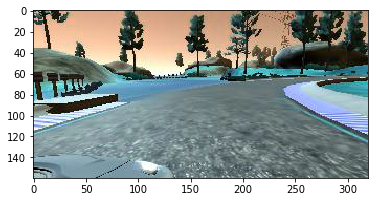

In [4]:
test_generator = data_generator(
    samples[0:10], 
    shape=(160,320,3), 
    batch_size=6, 
    correction=0.38,
    sensitivity=0.02,
    angle_threshold=0.6)

for i in range(1):
    X_batch, y_batch = next(test_generator)
    print('x shape = {}\ny shape = {}'.format(X_batch.shape, y_batch.shape))
    print(y_batch)
    plt.imshow(X_batch[0])
    plt.show()

# Keras modelling

In [5]:
import itertools

from contextlib import redirect_stdout

from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import Lambda, Cropping2D, MaxPooling2D, Flatten, Dense, SpatialDropout2D
from keras.layers.convolutional import Convolution2D
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [6]:
def build_model(input_shape, dropout):
    # model architecture based on
    # -> https://arxiv.org/pdf/1604.07316.pdf
    model = Sequential()

    # region of interest
    # Cropping2D((pixels_to_remove_from_top, from_bottom), (0, 0))
    model.add(Cropping2D(cropping=((60, 20), (0, 0)), input_shape=input_shape))

    # normalisation
    model.add(Lambda(lambda x: x / 255.0 - 0.5))

    # Convolution2D(filters, kernel, stride)
    model.add(Convolution2D(6, 5, 5, subsample=(2, 2), activation='elu', name='conv_1'))
    model.add(Convolution2D(12, 5, 5, subsample=(2, 2), activation='elu', name='conv_2'))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu', name='conv_3'))
    model.add(SpatialDropout2D(dropout))
    # model.add(Convolution2D(64, 3, 3, activation='elu'))
    # model.add(Convolution2D(64, 3, 3, activation='elu'))
    # model.add(SpatialDropout2D(dropout))

    # flatten
    model.add(Flatten(name='flatten'))

    # fully connected
    model.add(Dense(100, activation='elu', name='fc_1'))
    model.add(Dense(50, activation='elu', name='fc_2'))
    model.add(Dense(10, activation='elu', name='fc_3'))

    # output
    model.add(Dense(1, name='output'))

    # get model ready to run
    model.compile(optimizer=Adam(lr=1e-04), loss='mean_squared_error')
    
    return model

In [ ]:
# model hyper-parameters
epochs = [5]
batch_sizes = [10]
dropout = [0.15, 0.75]

# camera hyper-parameters
corrections = [0.15, 0.25, 0.35]
sensitivity = [0.05,]
angle_threshold = [0.01, 0.5, 0.75]

# set known image attributes
input_shape = (160, 320, 3)

# build grid
hyperparameters = [epochs, batch_sizes, dropout, corrections, sensitivity, angle_threshold]
grid = list(itertools.product(*hyperparameters))
len(grid)

18

In [ ]:
# perform grid search
for hyperparameters in grid:
    # set hyperparameters
    epochs = hyperparameters[0]
    batch_size = hyperparameters[1]
    dropout = hyperparameters[2]
    correction = hyperparameters[3]
    sensitivity = hyperparameters[4]
    angle_threshold = hyperparameters[5]
    
    # build model
    model = build_model(input_shape, dropout)

    # set train and validate sets
    train_samples, validation_samples = train_test_split(samples, test_size=0.3)

    # set generator functions
    train_generator = data_generator(
        train_samples, 
        shape=input_shape, 
        batch_size=batch_size, 
        correction=correction,
        sensitivity=sensitivity,
        angle_threshold=angle_threshold)

    validation_generator = data_generator(
        validation_samples,
        shape=input_shape,
        batch_size=batch_size,
        correction=correction,
        sensitivity=sensitivity,
        angle_threshold=angle_threshold)

    # create directories for logging and checkpointing
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run = '_'.join([str(h).replace('.','') for h in hyperparameters])
    log_dir = os.path.join(home_path, 'repos', 'udacity_carnd', 'project_3', 'log', '_'.join([timestamp, run]))
    model_dir = os.path.join(home_path, 'repos', 'udacity_carnd', 'project_3', 'model', '_'.join([timestamp, run]))
    
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
        print(log_dir)

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        print(model_dir)

    # get callbacks ready to run
    tb = TensorBoard(
        log_dir=log_dir, 
        histogram_freq=1, 
        write_graph=True, 
        write_images=True)

    chk = ModelCheckpoint(
        filepath=os.path.join(model_dir, 'model_{epoch:02d}_{val_loss:.4f}.h5'),
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False, 
        mode='auto', 
        period=1)

    # train the model
    history_object = model.fit_generator(
        train_generator,
        samples_per_epoch=len(train_samples),
        validation_data=validation_generator,
        nb_val_samples=len(validation_samples),
        nb_epoch=epochs,
        verbose=1,
        callbacks=[tb, chk])

    # save final epoch, as checkpoint callback won't
    final_model_name = '_'.join(['model_', 
                                 '{:02d}'.format(epochs), 
                                 '{:.4f}'.format(history_object.history['val_loss'][-1])]) + '.h5'
    final_model_path = os.path.join(model_dir, final_model_name)
    model.save(final_model_path)

    # plot the training and validation loss for each epoch
    f, ax = plt.subplots(figsize=(8, 3))
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    f.tight_layout()

    # save plot
    f.savefig(os.path.join(model_dir, 'epoch_history.png'))
                                    
    # save model.summary()
    # https://stackoverflow.com/a/40984270/893766
    with open(os.path.join(model_dir, 'model_summary.txt'), 'w') as f:
        with redirect_stdout(f):
            model.summary()


/home/carnd/repos/udacity_carnd/project_3/log/20170525_221405_5_10_015_015_005_001
/home/carnd/repos/udacity_carnd/project_3/model/20170525_221405_5_10_015_015_005_001
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This me

Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Inst

Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are cr

Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are cr

Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are cr

Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow 

Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow 

Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.merge_all.
Instructions for updating:
Please switch to tf.summary.merge.
Epoch 1/5
11249/11249 [==============================] - 79s - loss: 0.0152 - val_loss: 0.0109
Epoch 2/5
11249/11249 [==============================] - 80s - loss: 0.0100 - val_loss: 0.0089
Epoch 3/5
11249/11249 [==============================] - 79s - loss: 0.0085 - val_loss: 0.0078
Epoch 4/5
11249/11249 [==============================

Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow 

Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow 

Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Inst

Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.image. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, the max_images argument was renamed to max_outputs.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Inst

Epoch 1/5
11249/11249 [==============================] - 80s - loss: 0.0399 - val_loss: 0.0280
Epoch 2/5
  550/11249 [>.............................] - ETA: 62s - loss: 0.0294